In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Zip dosyasının olduğu yolu belirle (önceki adımdan aldığın yolu buraya yaz)
zip_path = "/content/drive/My Drive/MEDI-6.zip"

# Çıkarılacak klasörün yolu
extract_path = "/content/MEDI-6"

# Zip dosyasını aç ve içeriğini çıkart
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Dosyaların çıkarıldığını kontrol et
print("Dosyalar çıkarıldı. Klasör içeriği:")
print(os.listdir(extract_path))


Dosyalar çıkarıldı. Klasör içeriği:
['MEDI-6']


In [3]:
!pip install pynrrd


In [4]:
import nrrd

# NRRD dosyalarının tam yolunu belirle
scan_path = os.path.join(extract_path, "MEDI-6", "MEDI-6(SCAN).nrrd")
mask_path = os.path.join(extract_path, "MEDI-6", "MEDI-6(MASK).nrrd")

# Dosyaları oku
scan_data, _ = nrrd.read(scan_path)
mask_data, _ = nrrd.read(mask_path)

# Veri boyutlarını kontrol et
print("Scan Data Shape:", scan_data.shape)
print("Mask Data Shape:", mask_data.shape)


Scan Data Shape: (512, 512, 225)
Mask Data Shape: (512, 512, 225)


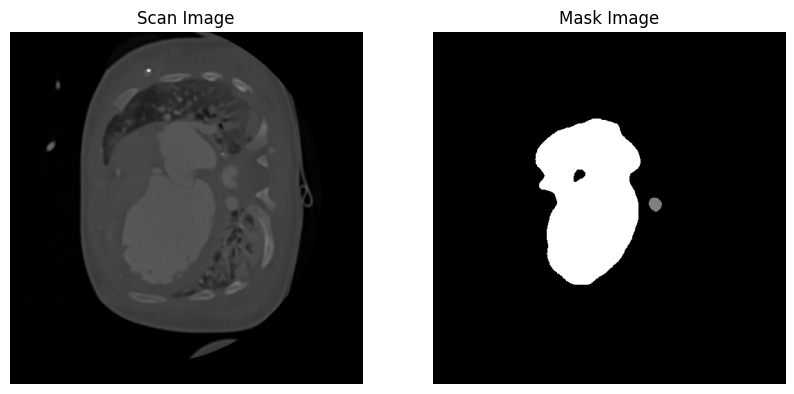

In [5]:
import matplotlib.pyplot as plt

# Orta seviyeden bir dilim seç
slice_index = scan_data.shape[2] // 2

# Görüntüyü ve maskeyi çiz
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Tarama görüntüsü
axes[0].imshow(scan_data[:, :, slice_index], cmap="gray")
axes[0].set_title("Scan Image")
axes[0].axis("off")

# Mask görüntüsü
axes[1].imshow(mask_data[:, :, slice_index], cmap="gray")
axes[1].set_title("Mask Image")
axes[1].axis("off")

plt.show()


In [6]:
import os
import pandas as pd
import nrrd

# Veri klasörü yolu
data_path = "/content/MEDI-6"

# Hasta klasörlerini bul
patients = sorted(os.listdir(data_path))

# Hasta ve dilim bilgilerini saklamak için liste
patient_slices = []

for patient_id in patients:
    patient_folder = os.path.join(data_path, patient_id)

    # Scan dosyasının yolunu belirle
    scan_path = os.path.join(patient_folder, f"{patient_id}(SCAN).nrrd")

    # Eğer dosya varsa, oku ve dilim sayısını al
    if os.path.exists(scan_path):
        scan_data, _ = nrrd.read(scan_path)
        num_slices = scan_data.shape[2]  # 3. boyut dilim sayısını temsil eder

        # Hastaya ait dilim sayısını listeye ekle
        patient_slices.append({"Patient ID": patient_id, "Number of Slices": num_slices})

# Sonuçları bir DataFrame'e çevir
df = pd.DataFrame(patient_slices)

# CSV olarak kaydet
csv_path = "/content/dilim_sayilari.csv"
df.to_csv(csv_path, index=False)

print("Dilim sayıları hesaplandı ve CSV dosyasına kaydedildi.")
print(df)


Dilim sayıları hesaplandı ve CSV dosyasına kaydedildi.
  Patient ID  Number of Slices
0     MEDI-6               225


In [7]:
!pip install torch torchvision torchaudio monai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [8]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import monai.transforms as transforms

# MRI taramalarını normalize eden dönüşüm fonksiyonları
transform = transforms.Compose([
    transforms.ScaleIntensity(),
    transforms.ToTensor(dtype=torch.float32)  # PyTorch tensörüne çevir
])

class MedicalDataset(Dataset):
    def __init__(self, scan, mask, transform=None):
        self.scan = scan
        self.mask = mask
        self.transform = transform

    def __len__(self):
        return self.scan.shape[2]  # Dilim sayısı kadar veri noktası var

    def __getitem__(self, idx):
        scan_slice = self.scan[:, :, idx]  # 2D dilim al
        mask_slice = self.mask[:, :, idx]  # 2D mask al

        # Kanal boyutunu ekleyelim (PyTorch formatına uygun hale getirmek için)
        scan_slice = np.expand_dims(scan_slice, axis=0)
        mask_slice = np.expand_dims(mask_slice, axis=0)

        # Dönüşümleri uygula
        if self.transform:
            scan_slice = self.transform(scan_slice)
            mask_slice = torch.tensor(mask_slice, dtype=torch.float32)  # Mask için doğrudan tensöre çevirme

        return scan_slice, mask_slice

# Veri kümesini oluştur
dataset = MedicalDataset(scan_data, mask_data, transform=transform)

# Veriyi DataLoader ile yükleyelim
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Bir batch'in boyutunu kontrol edelim
sample_scan, sample_mask = next(iter(train_loader))
print("Sample Scan Shape:", sample_scan.shape)
print("Sample Mask Shape:", sample_mask.shape)


Sample Scan Shape: torch.Size([4, 1, 512, 512])
Sample Mask Shape: torch.Size([4, 1, 512, 512])


In [9]:
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import VNet

# V-Net modelini yükle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VNet(spatial_dims=2, in_channels=1, out_channels=1).to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCEWithLogitsLoss()  # İkili segmentasyon için Binary Cross Entropy Loss kullanıyoruz
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model yüklendi ve eğitime hazır!")


Model yüklendi ve eğitime hazır!


In [10]:
# Eğitim fonksiyonu
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Modeli eğitim moduna al
    for epoch in range(num_epochs):
        running_loss = 0.0  # Toplam kaybı sıfırla
        for scans, masks in train_loader:
            scans, masks = scans.to(device), masks.to(device)  # Veriyi cihaza gönder (GPU/CPU)

            optimizer.zero_grad()  # Önceki gradyanları sıfırla
            outputs = model(scans)  # Modeli ileri geçir
            loss = criterion(outputs, masks)  # Kayıp hesapla
            loss.backward()  # Geri yayılım (backpropagation)
            optimizer.step()  # Optimizasyonu güncelle

            running_loss += loss.item()  # Kaybı toplama ekle

        # Epoch başına ortalama kaybı yazdır
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    print("Eğitim tamamlandı! ✅")

# Eğitimi başlat
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Loss: 0.8606
Epoch 2/10, Loss: 0.8153
Epoch 3/10, Loss: 0.7738
Epoch 4/10, Loss: 0.7306
Epoch 5/10, Loss: 0.6817
Epoch 6/10, Loss: 0.6306
Epoch 7/10, Loss: 0.5920
Epoch 8/10, Loss: 0.5730
Epoch 9/10, Loss: 0.5205
Epoch 10/10, Loss: 0.4905
Eğitim tamamlandı! ✅


In [11]:
import numpy as np
import torch.nn.functional as F

# Dice Skoru Hesaplayan Fonksiyon
def dice_coefficient(y_pred, y_true, threshold=0.5):
    y_pred = (F.sigmoid(y_pred) > threshold).float()  # Sigmoid uygula ve eşik değere göre binarize et
    intersection = torch.sum(y_pred * y_true) * 2.0  # Kesişimi hesapla
    union = torch.sum(y_pred) + torch.sum(y_true)  # Birleşimi hesapla
    dice = (intersection + 1e-7) / (union + 1e-7)  # Bölmeyi güvenli hale getir
    return dice.item()

# Modeli test etme fonksiyonu
def test_model(model, test_loader):
    model.eval()  # Modeli değerlendirme moduna al
    dice_scores = []

    with torch.no_grad():  # Gradyan hesaplamasını kapat
        for scans, masks in test_loader:
            scans, masks = scans.to(device), masks.to(device)  # Veriyi cihaza gönder
            outputs = model(scans)  # Model tahmini al
            dice = dice_coefficient(outputs, masks)  # Dice skorunu hesapla
            dice_scores.append(dice)

    mean_dice = np.mean(dice_scores)  # Ortalama Dice skoru
    print(f"Ortalama Dice Skoru: {mean_dice:.4f}")

# Test loader oluştur (aynı veri kümesini test için kullanıyoruz)
test_loader = DataLoader(dataset, batch_size=4, shuffle=False)

# Testi çalıştır
test_model(model, test_loader)


Ortalama Dice Skoru: 0.1113


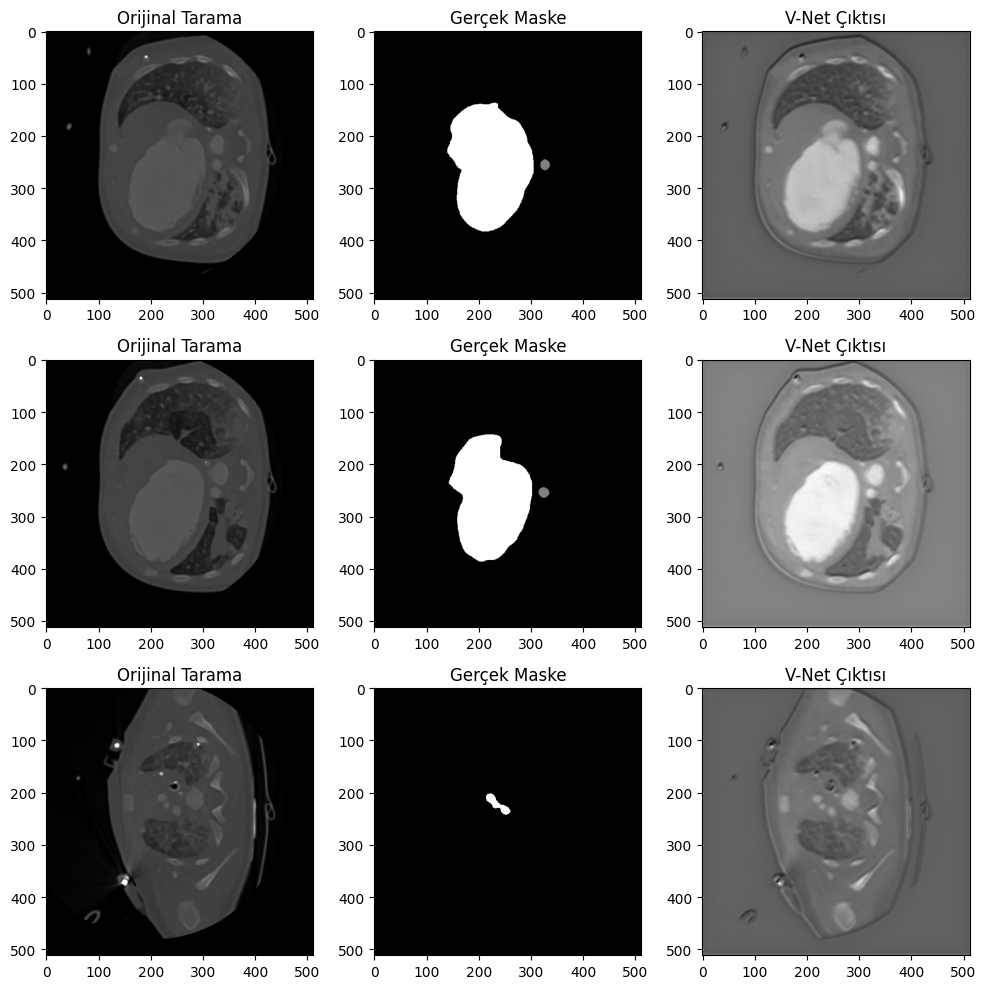

In [16]:
import matplotlib.pyplot as plt

# Modeli test moduna al
model.eval()

# Bir batch veri al
scans, masks = next(iter(train_loader))
scans, masks = scans.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(scans)
    outputs = torch.sigmoid(outputs)  # Maskeleri sigmoid fonksiyonundan geçir

# İlk 3 görüntüyü görselleştirelim
num_samples = 3

fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))

for i in range(num_samples):
    # Orijinal tarama görüntüsü
    axes[i, 0].imshow(scans[i, 0].cpu().numpy(), cmap='gray')
    axes[i, 0].set_title("Orijinal Tarama")

    # Gerçek maske
    axes[i, 1].imshow(masks[i, 0].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title("Gerçek Maske")

    # Model çıktısı
    axes[i, 2].imshow(outputs[i, 0].cpu().numpy(), cmap='gray')
    axes[i, 2].set_title("V-Net Çıktısı")

plt.tight_layout()
plt.show()
